In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import modules as mod
import networkx as nx
from scipy.optimize import curve_fit

### Global parameters

In [2]:
# Number of market participants 
N = 1600 

# Number of fundamentalists and chartists
N_FUND = 800
N_CHART = 800

# Initial price of the asset traded
P_0 = 100

# Global fundamental price 
P_F = 120

# Variation around the global fundamental price 
THETA = 30

# Maximum extension for chartists' timesteps window 
T_MAX = 15

# Sensitivity of forecasts for fundamentalists
PHI = 2.0

# Sensitivity of forecasts for chartists 
KAPPA = 2.0

# level of information dissipation among the agents
ALPHA = 0.95

# Weight of the market imbalance
DELTA = 0.05

# Intervals of variation for the stochastic noise term 
SIGMA = 30

# Sensitivity threshold for choosing the status
TAO = 20

# Asset quantity for each trader
Q = 50

# Information Threshhold
Ith = 1

# Initializing traders' wealth (W), money (M), and asset quantity(Q)
M = 35000  
Q = 50 
W = [M + Q * P_0 for _ in range(N)] 

In [3]:
# Function to calculate expected price for one fundamentalist
def ep_fundamentalist(p_t, P_F):
    """
    Calculate the expected price for a fundamentalist trader

    Parameters:
    p_t (float): The current market price of the asset
    p_f (float): The perceived fundamental price of the asset for the trader

    Returns:
    float: The expected price for the asset for a fundamentalist trader
    """
    noise = np.random.uniform(-SIGMA, SIGMA)
    # Was not too sure about using an uniform or normal distribution here
    p_f = np.random.uniform(P_F - THETA, P_F + THETA)
    return p_t + PHI * (p_f - p_t) + noise

# Function to calculate expected price for one chartist
def ep_chartist(p_t, past_prices):
    """
    Calculate the expected price for a chartist trader

    Parameters:
    p_t (float): The current market price of the asset
    past_prices (list of float): A list of past market prices of the asset

    Returns:
    float: The expected price for the asset as calculated by a chartist trader
    """
    assert len(past_prices) == T_MAX, "past_prices must be a list of 15 values"
    chartist_T = np.random.randint(2, T_MAX)
    p_T = np.mean(past_prices[-chartist_T:]) 
    noise = np.random.uniform(-SIGMA, SIGMA)
    return p_t + KAPPA/(chartist_T) * (p_t - p_T) + noise

# Function that determines the choice one random trader makes
def rand_trader():
    choice = np.random.randint(0, 3)
    return choice
    

### 

In [4]:
# Function to calculate the order type for a non-random trader
def determine_order_type(expected_price, p_t, TAO, money, asset_quantity):
    """
    Determine the order type of a trader based on the expected price, current price,
    sensitivity threshold, available money, and asset quantity

    Parameters:
    expected_price (float): The expected price of the asset
    p_t (float): The current market price of the asset
    TAO (int): The threshold to decide whether to hold
    money (float): The amount of money the trader has
    asset_quantity (int): The quantity of the asset the trader holds

    Returns:
    str: The order type ('buy', 'sell', or 'hold')
    """

    if abs(expected_price - p_t) < TAO:
        return 'hold'
    elif expected_price > p_t and money > 0:
        return 'buy'
    elif expected_price < p_t and asset_quantity > 0:
        return 'sell'
    else:
        return 'hold'

def set_order_price(order_type, expected_price, current_price, money):
    """
    Set the order price for a trader based on their order type, expected price,
    current price, and the amount of money they have

    Parameters:
    order_type (str): The type of order ('buy', 'sell', or 'hold')
    expected_price (float): The expected price of the asset
    current_price (float): The current market price of the asset
    money (float): The amount of money the trader has
    
    Returns:
    float: The price set for the order
    """
    if order_type == 'buy':
        return np.random.uniform(0, min(money, expected_price))
    elif order_type == 'sell':
        return np.random.uniform(expected_price, current_price)
    else:
        return 0

In [5]:
# Example usage
current_market_price = P_0
trader_money = M
trader_asset_quantity = Q

ep = ep_fundamentalist(current_market_price, P_F) 
order_type = determine_order_type(ep, P_0, TAO, trader_money, trader_asset_quantity)
order_price = set_order_price(order_type, ep, current_market_price, trader_money)

print(ep)
print(order_type)
print(order_price)

186.22823827106518
buy
180.0476678930365


In [6]:
# Initialize agent attributes at T = 0

# structure of agent data
# agents = np.zeros(N, dtype=[('type', 'U10'),# 0
#                             ('wealth', 'f8'),# 1
#                             ('money', 'f8'), # 2
#                             ('assets', 'f8'), # 3
#                             ('expected_price', 'f8'), # 4
#                             ('decision', 'U10'), # 5
#                             ('info', 'f8')]) # 6

agents_dict = {}
past_price = np.repeat(P_0, T_MAX)
for i in range(N_FUND):
    ep = ep_fundamentalist(current_market_price, P_F) 
    
    agents_dict[i] = ('fund',
                 W[i],
                 M,
                 Q,
                 ep,
                 determine_order_type(ep, P_0, TAO, trader_money, trader_asset_quantity),
                 np.random.uniform(0, Ith)
                )

# Start from where N_FUND stops for integers
# for i in range(N_FUND, N_FUND+N_CHART):
#     ep = ep_chartist(current_market_price, past_price)
#     agents_dict[i] = ('chart',
#                  W[i],
#                  M,
#                  Q,
#                  ep,
#                  determine_order_type(ep, P_0, TAO, trader_money, trader_asset_quantity),
#                  np.random.uniform(0, Ith)
#                 )


In [7]:
class OrderBook:
    def __init__(self, delta, alpha, agents_dict, info_counts, state_counts):
        """
        Initialize the OrderBook with the given delta value.

        Parameters:
        - delta (float): Parameter for price adjustment.
        """
        self.bids = []  # List to store bid orders
        self.asks = []  # List to store ask orders
        self.delta = delta  # Parameter for price adjustment
        self.N_a = 0 # Number of asks
        self.N_b = 0 # Number of bids
        self.N_T = 0 # Number of trades
        self.agents_dict = agents_dict # Dictionary containing each agents and information
        self.network = nx.watts_strogatz_graph(n=N, k=4, p=0.4) 
        self.state_counts = state_counts
        self.info_counts = info_counts
        self.alpha = alpha
        self.Ith = Ith
        
    def place_bid(self, trader_id, price):
        """
        Place a bid order in the order book.

        Parameters:
        - trader_id (int): ID of the trader placing the bid.
        - price (float): Bid price.
        """
        self.bids.append({'trader_id': trader_id, 'price': price})
        self.N_b += 1  # Increment the number of bidders
        
    def place_ask(self, trader_id, price):
        """
        Place an ask order in the order book.

        Parameters:
        - trader_id (int): ID of the trader placing the ask.
        - price (float): Ask price.
        """
        self.asks.append({'trader_id': trader_id, 'price': price})
        self.N_a += 1  # Increment the number of askers
        
    def propagate_info(self, agent_index):
        """
        Propagate the information of an agent to its neighbors in the network.

        If the agent's information is greater than or equal to the threshold `Ith`, 
        the information is stored and the agent's information is set to 0. Then, 
        the stored information is distributed to each neighbor in proportion to `ALPHA / number of neighbors`. 
        If the distributed information is greater than or equal to the threshold `Ith`, 
        the agent's decision is propagated to the neighbor, and the `propagate_info` function is recursively called.

        Parameters:
        agent_index (int): The index of the agent in the agents list.
        """
        agent = self.agents_dict[agent_index]
        neighbors = list(self.network.neighbors(agent_index))
        if agent[6] >= self.Ith: # 6 is index for info 
            self.info_counts[-1] += 1
            store_info = agent[6]
            self.agents_dict[agent_index][6] = 0 # TAKE A GOOD LOOK WHETHER THIS IS CORRECT ON THE SIM
            for neighbor in neighbors:
                self.agents_dict[neighbor][6] += (self.alpha / len(neighbors)) * store_info
                self.agents_dict[neighbor][6] = min(self.agents_dict[neighbor][6], np.finfo(float).max)
                if self.agents_dict[neighbor][6] >= self.Ith:
                    self.agents_dict[neighbor][5] = agent[5] # 5 is decision
                    self.propagate_info(neighbor)  # Recursive call
        
    def network_cycle(self):
        """
        Update the network for one simulation cycle and collect information for futures plots.
        """
        self.info_counts.append(0) # Agent information threshhold cross counter
        copy_agents = self.agents_dict.copy()
        # Add global information
        for agent_id in self.agents_dict:
            self.agents_dict[agent_id][6] += np.random.uniform(0, 
                                            (self.Ith - max([copy_agents[agent_id][6] for agent_id in copy_agents])))
        # Contagion mechanism
        for i, agent in enumerate(self.agents_dict):
            self.propagate_info(i)

        current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
        for agent_id in self.agents_dict:
            current_state_counts[self.agents_dict[agent_id][5]] += 1
        for state in self.state_counts:
            self.state_counts[state].append(current_state_counts[state])
                
    def match_orders(self):
        """
        Match bid and ask orders in the order book.

        Returns:
        - list: List of dictionaries representing matched transactions.
        """
        self.bids.sort(key=lambda x: x['price'], reverse=True)
        self.asks.sort(key=lambda x: x['price'])
        N_T = 0 
        while self.bids and self.asks:
            best_bid = self.bids[0]
            best_ask = self.asks[0]

            if best_bid['price'] >= best_ask['price']:
                # Remove matched orders
                p_L = self.asks[0]['price']
                self.agents_dict[self.asks[0]['trader_id']][3] -= 1 ## assets
                self.agents_dict[self.bids[0]['trader_id']][3] += 1 
                self.agents_dict[self.asks[0]['trader_id']][2] += p_L  
                self.agents_dict[self.bids[0]['trader_id']][2] -= p_L
                self.bids.pop(0)
                self.asks.pop(0)
                self.N_b -= 1
                self.N_a -= 1
                N_T += 1
            
            else:
                break  # No more possible transactions

        return N_T, p_L

    def set_aggregate_price(self, prev_price):
        """
        Set the aggregate asset price at time t + 1 based on different cases.

        Parameters:
        - prev_price (float): Previous global asset price at time t.
        - N_a (int): Number of askers in the order book.
        - N_b (int): Number of bidders in the order book.

        Returns:
        - float: New global asset price at time t + 1.
        """

        if self.N_a == 0 and self.N_b > 0:
            new_price = prev_price + self.delta * self.N_b
        elif self.N_a > 0 and self.N_b == 0:
            new_price = prev_price - self.delta * self.N_a
        elif 0 < self.N_a < self.N_b and self.bids[0]['price'] < self.asks[0]['price']:
            new_price = prev_price + self.delta * self.N_b
        elif 0 < self.N_a < self.N_b and self.bids[0]['price'] > self.asks[0]['price']:
            N_T,p_L = self.match_orders()
            new_price = p_L + self.delta * (self.N_b - N_T)
        elif 0 < self.N_b < self.N_a and self.bids[0]['price'] <= self.asks[0]['price']:
            new_price = prev_price - self.delta * self.N_a
        elif 0 < self.N_b < self.N_a and self.bids[0]['price'] > self.asks[0]['price']:
            N_T, p_L = self.match_orders()
            new_price = p_L - self.delta * (self.N_a - N_T)
        else:
            new_price = prev_price
        
        return new_price


### Simulation

In [8]:
# Initialize agent attributes at T = 0

# structure of agent data
# agents = np.zeros(N, dtype=[('type', 'U10'),# 0
#                             ('wealth', 'f8'),# 1
#                             ('money', 'f8'), # 2
#                             ('assets', 'f8'), # 3
#                             ('expected_price', 'f8'), # 4
#                             ('decision', 'U10'), # 5
#                             ('info', 'f8')]) # 6

agents_dict = {}
past_price = [P_0 for i in range(T_MAX)]
state_counts = {'buy': [], 'sell': [], 'hold': []}
ob = OrderBook(DELTA, ALPHA, agents_dict, info_counts = [], state_counts = state_counts)
current_market_price = P_0
simulations = 10000
asset_prices = []
for i in range(N_FUND):
    ep = ep_fundamentalist(P_0, P_F)
    #print(ep) 
    agents_dict[i] = ['fund',
                 W[i],
                 M,
                 Q,
                 ep,
                 determine_order_type(ep, P_0, TAO, M, Q),
                 np.random.uniform(0, Ith)
                     ]

# # Start from where N_FUND stops for integers
for i in range(N_FUND, N_FUND+N_CHART):
    ep = ep_chartist(P_0, past_price)
    agents_dict[i] = ['chart',
                 W[i],
                 M,
                 Q,
                 ep,
                 determine_order_type(ep, P_0, TAO, trader_money, trader_asset_quantity),
                 np.random.uniform(0, Ith)
                     ]

In [9]:
# Simulation 1 cycle
# Check #5, decision in dict to get decision
for sim in range(simulations):
    ob.network_cycle()
    for agent_id in ob.agents_dict:
        decision = ob.agents_dict[agent_id][5]
        order_price = set_order_price(decision, ob.agents_dict[agent_id][4], current_market_price, ob.agents_dict[agent_id][2])
        if decision == "buy":
            ob.place_bid(agent_id, order_price)
        elif decision == "sell":
            ob.place_ask(agent_id, order_price)
            
    current_market_price = ob.set_aggregate_price(current_market_price)
    
    asset_prices.append(current_market_price)
    past_price.pop()
    past_price.append(current_market_price)
    
    for agent_id in range(N_FUND): 
        ep = ep_fundamentalist(current_market_price, P_F) 
        ob.agents_dict[agent_id][4] = ep
        ob.agents_dict[agent_id][5] = determine_order_type(ep,
                                                    current_market_price, 
                                                    TAO, ob.agents_dict[agent_id][2],
                                                    ob.agents_dict[agent_id][3])
    for agent_id in range(N_FUND, N_FUND+N_CHART):
        ep = ep_chartist(current_market_price, past_price) 
        ob.agents_dict[agent_id][4] = ep
        ob.agents_dict[agent_id][5] = determine_order_type(ep,
                                                    current_market_price, 
                                                    TAO, ob.agents_dict[agent_id][2],
                                                    ob.agents_dict[agent_id][3])
    ob = OrderBook(DELTA, ALPHA, ob.agents_dict, ob.info_counts, ob.state_counts)

Text(0, 0.5, 'Price')

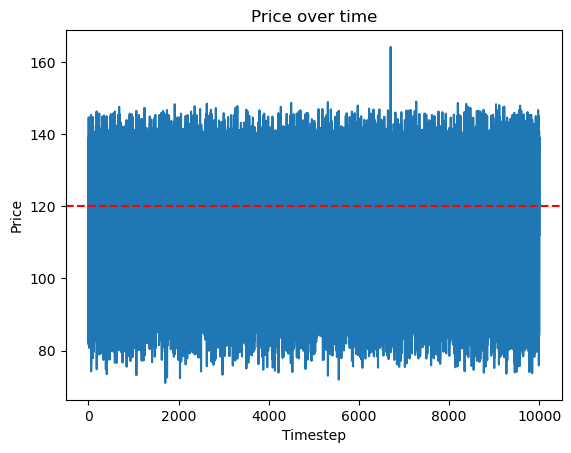

In [ ]:
plt.plot(list(range(simulations)), asset_prices, label ='asset price')
plt.axhline(y=120, color='r', linestyle='--', label='fundamental price 120')
plt.title("Price over time")
plt.xlabel("Timestep")
plt.ylabel("Price")

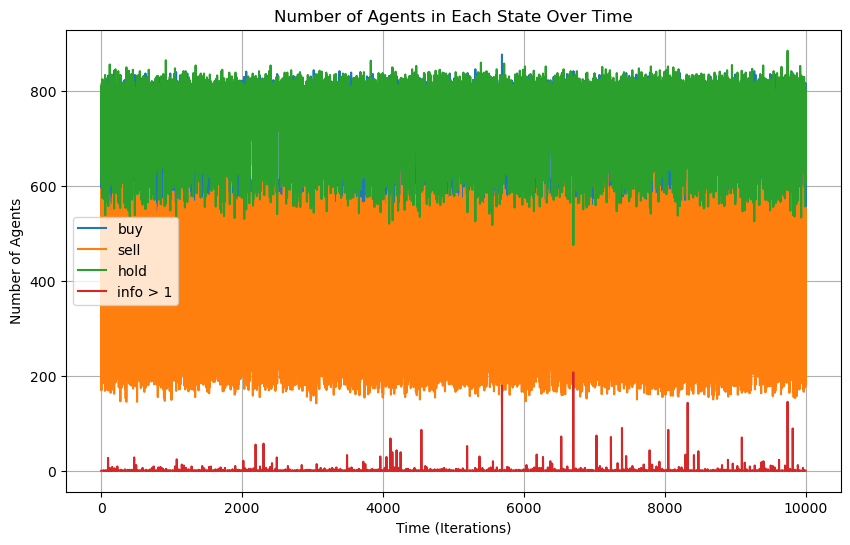

In [ ]:
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in ob.state_counts.items():
    plt.plot(range(len(counts)), counts, label=state)
plt.plot(range(len(ob.info_counts)), ob.info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.savefig("soc_network.png")
plt.show()

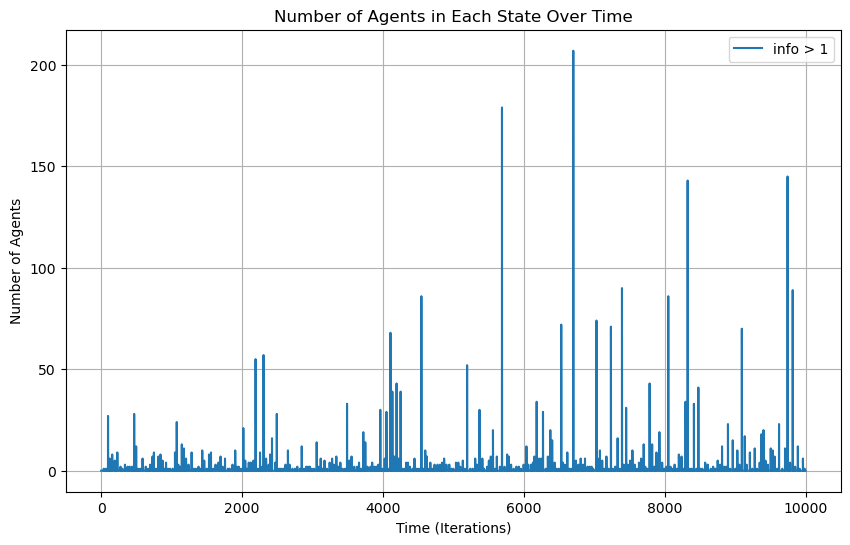

In [ ]:
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
# for state, counts in ob.state_counts.items():
#     plt.plot(range(len(counts)), counts, label=state)
plt.plot(range(len(ob.info_counts)), ob.info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Size of Info Avalanches')
plt.title('Time Series of the Informative Avalanches Size')
plt.legend()
plt.grid(True)
plt.savefig("soc_network.png")
plt.show()

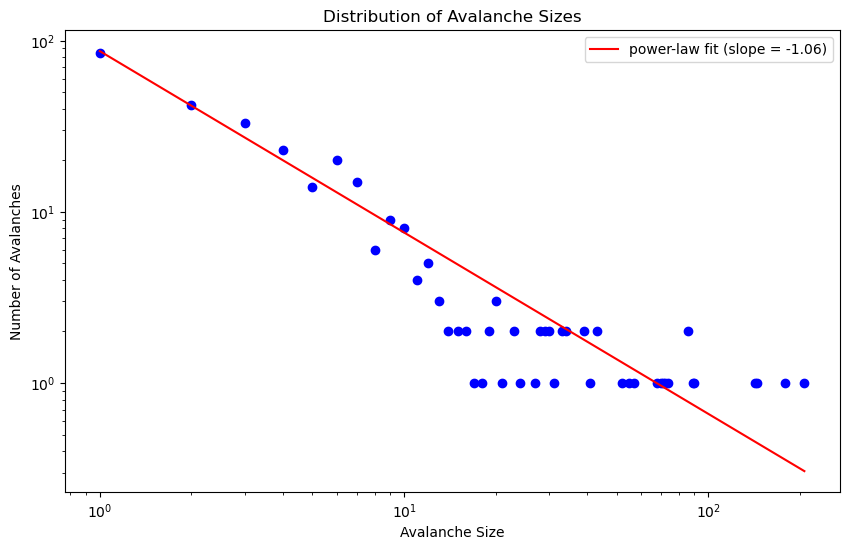

In [ ]:
# Filter out the time steps where no avalanche occurred
avalanche_sizes = np.array(ob.info_counts)
avalanche_sizes = avalanche_sizes[avalanche_sizes > 0]

# Calculate the unique avalanche sizes and their counts
avalanche_sizes, counts = np.unique(avalanche_sizes, return_counts=True)

# Define the power-law function for fitting
def power_law(x, a, b):
    return a * np.power(x, b)

# Fit the power-law curve to the data
params, _ = curve_fit(power_law, avalanche_sizes, counts)

# Unpack fitting parameters for plotting
a, b = params

plt.figure(figsize=(10, 6))
plt.scatter(avalanche_sizes, counts, color='blue')  # Scatter plot of the raw data

# Generate points for the fitted line
fitted_line = power_law(avalanche_sizes, a, b)

# Plot the fitted line
plt.plot(avalanche_sizes, fitted_line, label=f'power-law fit (slope = {b:.2f})', color='red')

# Set the plot to log-log scale
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Avalanche Size')
plt.ylabel('Number of Avalanches')
plt.title('Distribution of Avalanche Sizes')

plt.legend()
plt.show()